In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')scr

Mounted at /content/gdrive/


In [ ]:
import os
os.chdir("/content/gdrive/My Drive/dataset)
os.getcwd()

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import math

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.datasets as dset
from torchvision.utils import save_image
import torchvision.utils as vutils
from torchsummary import summary
from IPython import display
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

Parameter Settings

In [ ]:

latent_dims = 2
num_epochs = 100
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

In [ ]:
dataroot = "./"
image_size = 128
nb_channls=3
workers=4
test_batch_size = 2
weight_decay = 1e-5




device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

Data Loading


In [ ]:
# Load Dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize((image_size, image_size)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

train_splitRatio = 0.8
train_len = int(train_splitRatio * len(dataset))
test_len = len(dataset) - train_len

print(train_len)
trainData, testData = torch.utils.data.random_split(dataset,[train_len, test_len])

dataloader_train = torch.utils.data.DataLoader(trainData, batch_size=batch_size,
                                         shuffle=True, num_workers=workers,drop_last=True)

dataloader_test = torch.utils.data.DataLoader(testData, batch_size=test_batch_size,
                                         shuffle=False, num_workers=workers,drop_last=True)

5413


VAE Definition

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=c, kernel_size=4, stride=2, padding=1) 
        #self.conv1_bn = nn.BatchNorm2d(c)
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1)
        #self.conv2_bn = nn.BatchNorm2d(c*2)
        self.fc_mu = nn.Linear(in_features=c*2*32*32, out_features=latent_dims)
        #self.fc_mu_bn = nn.BatchNorm1d(latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*32*32, out_features=latent_dims)
        #self.fc_logvar_bn = nn.BatchNorm1d(latent_dims)
            
    def forward(self, x):
        x = F.relu((self.conv1(x)))
        x = F.relu((self.conv2(x)))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = (self.fc_mu(x))
        x_logvar = (self.fc_logvar(x))
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*32*32)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        #self.conv2_bn = nn.BatchNorm2d(c)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=3, kernel_size=4, stride=2, padding=1)
        #self.conv1_bn = nn.BatchNorm2d(3)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 32, 32) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu((self.conv2(x)))
        x = torch.sigmoid((self.conv1(x))) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar):
   
    mse_loss = nn.MSELoss(reduction="sum")
    loss_MSE = mse_loss(recon_x, x)
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    kldivergence /= batch_size
    
    return loss_MSE + variational_beta * kldivergence
    
    
vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)


Number of parameters: 1186055


In [ ]:
summary(vae, (nb_channls, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,136
            Conv2d-2          [-1, 128, 32, 32]         131,200
            Linear-3                    [-1, 2]         262,146
            Linear-4                    [-1, 2]         262,146
           Encoder-5         [[-1, 2], [-1, 2]]               0
            Linear-6               [-1, 131072]         393,216
   ConvTranspose2d-7           [-1, 64, 64, 64]         131,136
   ConvTranspose2d-8          [-1, 3, 128, 128]           3,075
           Decoder-9          [-1, 3, 128, 128]               0
Total params: 1,186,055
Trainable params: 1,186,055
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 6.75
Params size (MB): 4.52
Estimated Total Size (MB): 11.46
--------------------------------------

Train VAE


In [ ]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in dataloader_train:
        
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 100] average reconstruction error: 3316156.500000
Epoch [2 / 100] average reconstruction error: 3227932.886905
Epoch [3 / 100] average reconstruction error: 3143409.672619
Epoch [4 / 100] average reconstruction error: 3067079.880952
Epoch [5 / 100] average reconstruction error: 2998941.196429
Epoch [6 / 100] average reconstruction error: 2932161.767857
Epoch [7 / 100] average reconstruction error: 2868755.434524
Epoch [8 / 100] average reconstruction error: 2810749.369048
Epoch [9 / 100] average reconstruction error: 2753740.589286
Epoch [10 / 100] average reconstruction error: 2700309.869048
Epoch [11 / 100] average reconstruction error: 2648283.523810
Epoch [12 / 100] average reconstruction error: 2599499.571429
Epoch [13 / 100] average reconstruction error: 2555055.315476
Epoch [14 / 100] average reconstruction error: 2515107.952381
Epoch [15 / 100] average reconstruction error: 2472539.434524
Epoch [16 / 100] average reconstruction error: 2435179.488095
Epoc

Plot Training Curve

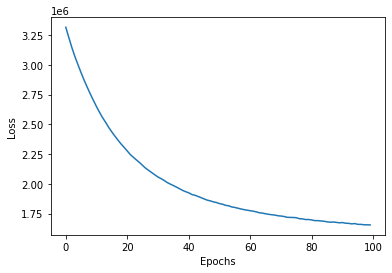

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Evaluate on the Test Set

In [ ]:
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in dataloader_test:
    
    with torch.no_grad():
    
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fcc75330ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fcc75330ba8>>
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Traceback (most recent call last):
AssertionError: can only join a child process
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

average reconstruction error: 25514.449980


In [ ]:
device

device(type='cuda', index=0)

Visualize Reconstructions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(dataloader_test).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

In [ ]:
#%debug
